In [751]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [752]:
!ls track

driving_log.csv  IMG


In [753]:
!pip3 install imgaug

In [0]:
#importing liberaries

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import ntpath
import pandas as pd
import random

In [755]:
# displaying driving_log.csv

datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [756]:
#removing the head from the file paths

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

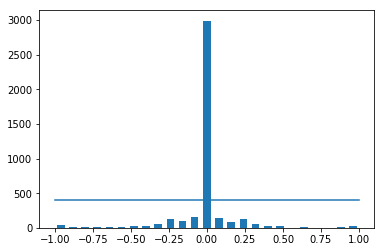

In [757]:
# displaying the histogram of the dataset

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2590
remaining: 1463


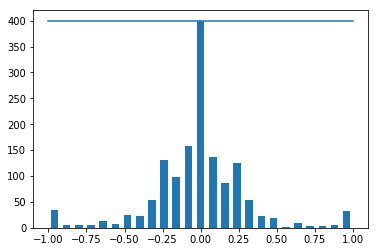

In [758]:
# removing the top bar of center fro . position 400 as it would have made the data too center biased

print('total data:', len(data))
remove_list = []

for j in range(num_bins):                                                        # This loop is going through each bin and each steering angle.
  list_ = []                                                                     # All the steering values coming under the steering value at that perticular bin it appends it in the list_
  for i in range(len(data['steering'])):                                         # The list_ is then added to a list called remove_list, so that all the elements in the remove list can be dropped to remove the swkewness
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [759]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]                                                  # Through this loop we are adding all the images (center, left, right) with their respective paths in a list called image_path
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]      # All their respective steering angles are stored in a list called steering
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)                                           # Here both the image_path and steering are converted into array with names image_paths and steerings respectively
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_44_137.jpg
left        left_2018_07_16_17_11_44_137.jpg  
right       right_2018_07_16_17_11_44_137.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.59835                           
Name: 8, dtype: object


In [760]:
# Here all the above data(image_pats, steerings) is being split into training set(80%) and validation set(20%)

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

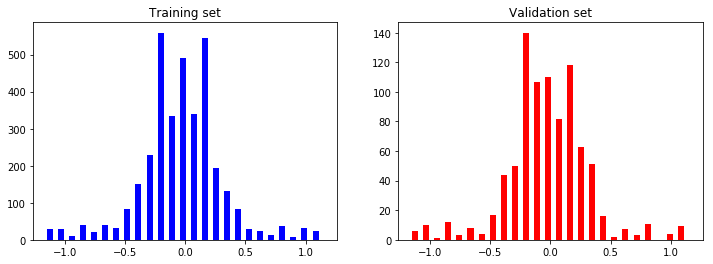

In [761]:
# Here training set and validation set is being displayed (histogram)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
# From here different data augmentation functions are defined which will be then applies to our images to make more variety for training set

# Zoom function
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

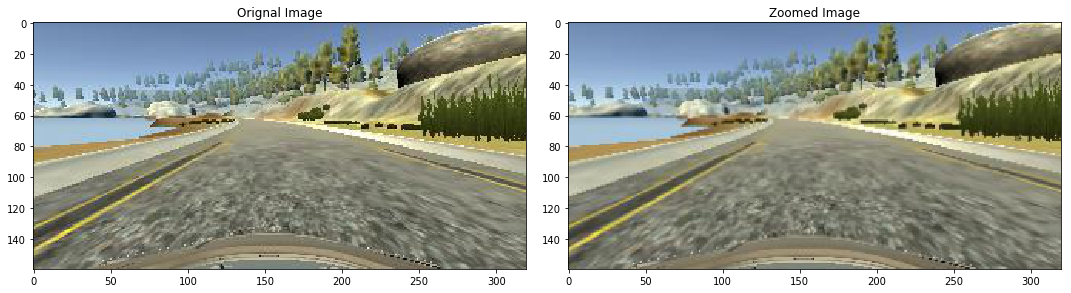

In [763]:
# Zoom function is being displayed on any random image from data set

image = image_paths[random.randint(0, 1000)]
orignal_img = mpimg.imread(image)
zoom_img = zoom(orignal_img)
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(orignal_img)
axs[0].set_title('Orignal Image')
axs[1].imshow(zoom_img)
axs[1].set_title('Zoomed Image')

In [0]:
# Pan function

def pan(image):
  pan = iaa.Affine(translate_percent = {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned Image')

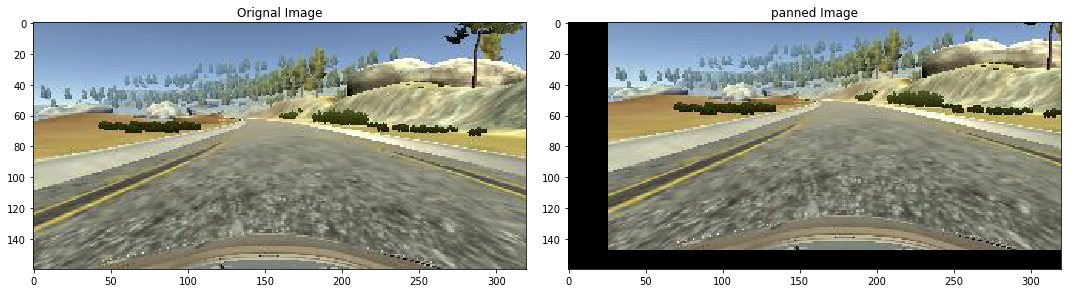

In [765]:
# Pan function is being displayed on any random image from data set

image = image_paths[random.randint(0, 1000)]
orignal_img = mpimg.imread(image)
pan_img = pan(orignal_img)
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(orignal_img)
axs[0].set_title('Orignal Image')
axs[1].imshow(pan_img)
axs[1].set_title('panned Image')

In [0]:
# Image random brightness function

def img_random_brightness(image):
  bright = iaa.Multiply((0.2, 1.2))
  image = bright.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness altered Image')

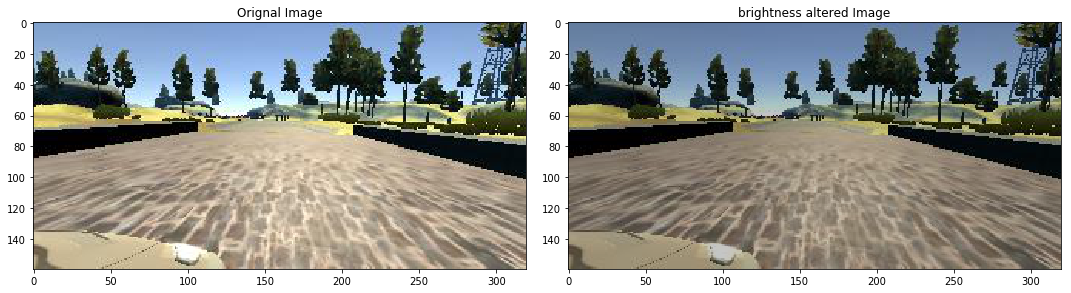

In [767]:
# Image random brightness function is being displayed on any random image from data set

image = image_paths[random.randint(0, 1000)]
orignal_img = mpimg.imread(image)
bright_img = img_random_brightness(orignal_img)
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(orignal_img)
axs[0].set_title('Orignal Image')
axs[1].imshow(bright_img)
axs[1].set_title('brightness altered Image')

In [0]:
# Random image flip function

def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image  -  Steering angle: 0.07241428')

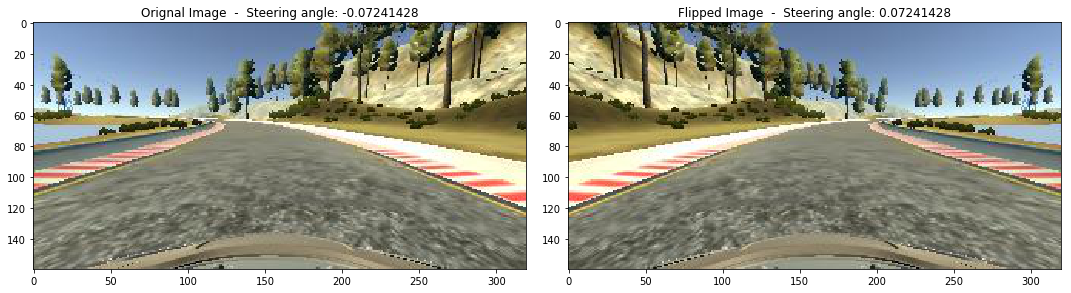

In [769]:
# Random image flip function is being displayed on any random image from data set

image = image_paths[random.randint(0, 1000)]
steering_angle = steerings[random.randint(0, 1000)]
orignal_img = mpimg.imread(image)
flip_img, flipped_steering_angle = img_random_flip(orignal_img, steering_angle)
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(orignal_img)
axs[0].set_title('Orignal Image  -' + "  Steering angle: "+str(steering_angle))
axs[1].imshow(flip_img)
axs[1].set_title('Flipped Image  -' + "  Steering angle: "+str(flipped_steering_angle))

In [0]:
# This block of code randomly applies the above augmented functions on the images 50% of the time

def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

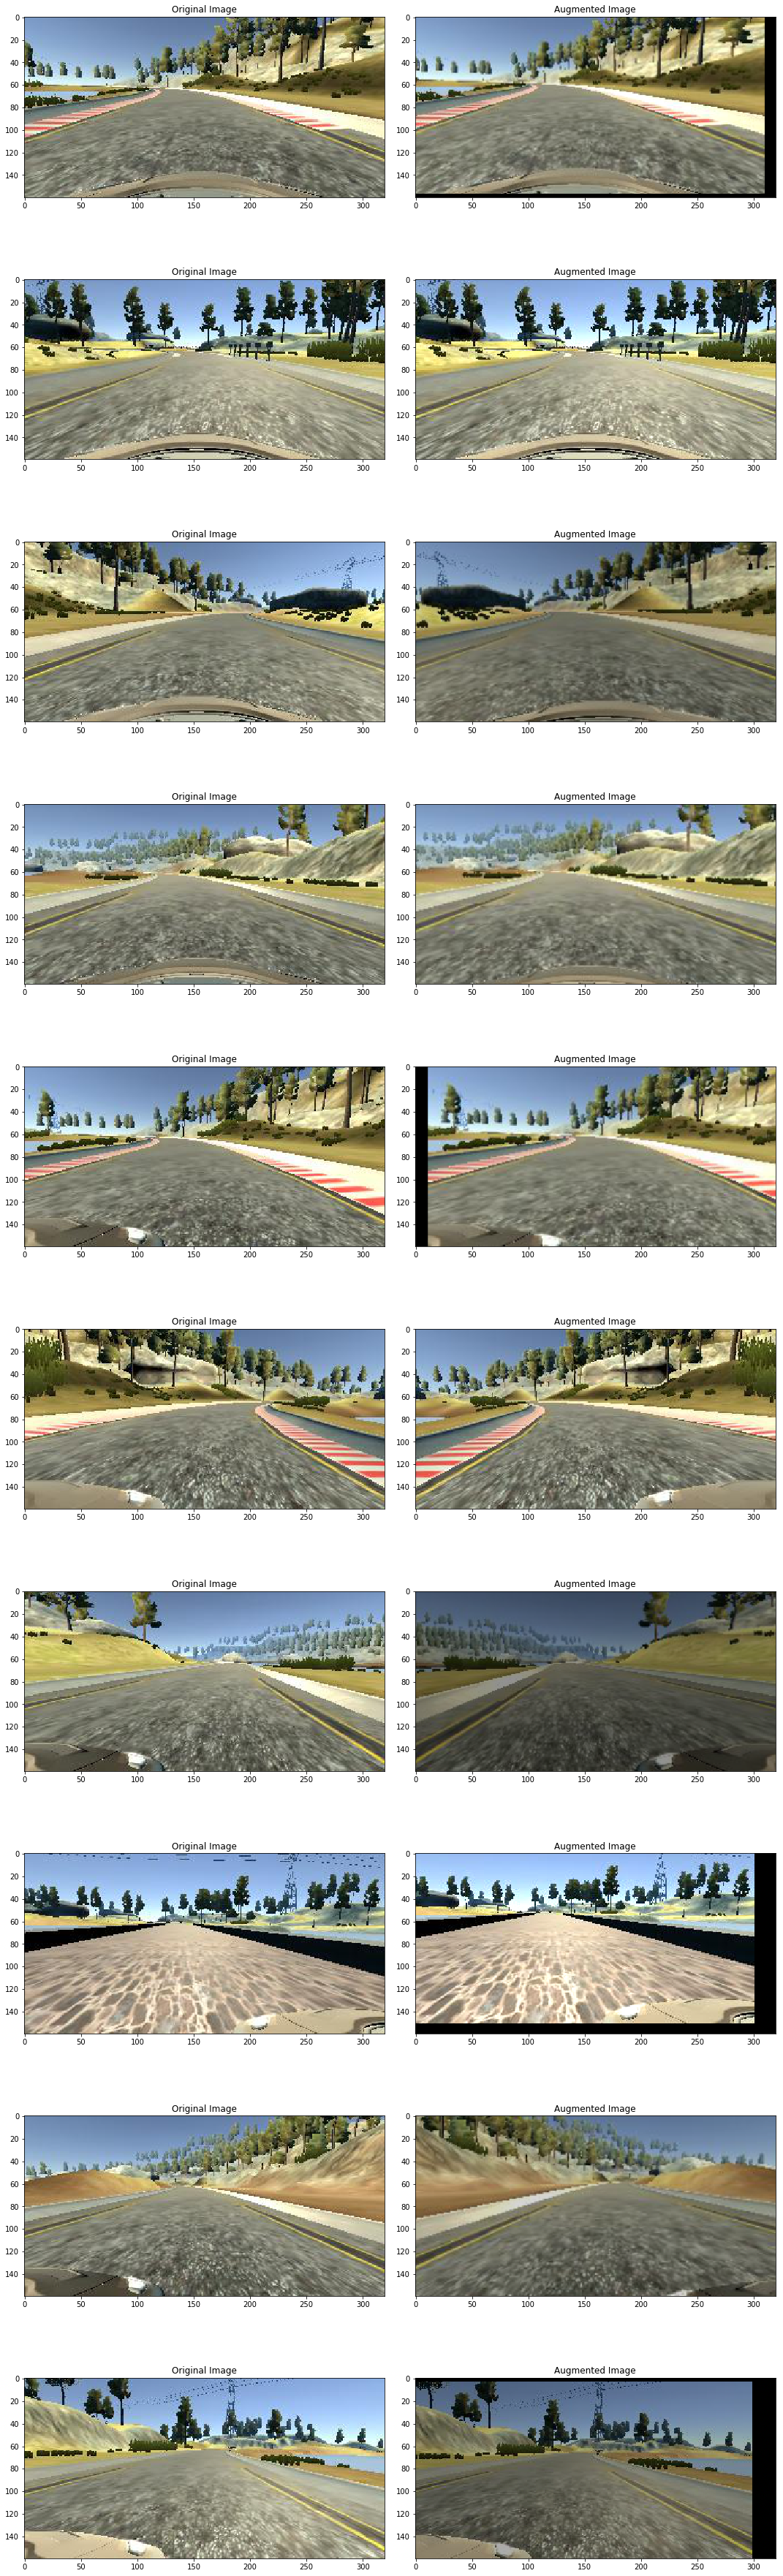

In [771]:
# This block of code displays random 10 images on which randomly augmented functions are applied

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
# Here is the function for image processing 

def img_preprocessing(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)       # Color is changed from RBG to YUV (as ml performs better on that)
  img = cv2.GaussianBlur(img, (3, 3), 0)           # Gaussian blurr is used to remove the noise from the image
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Brightness altered image ')

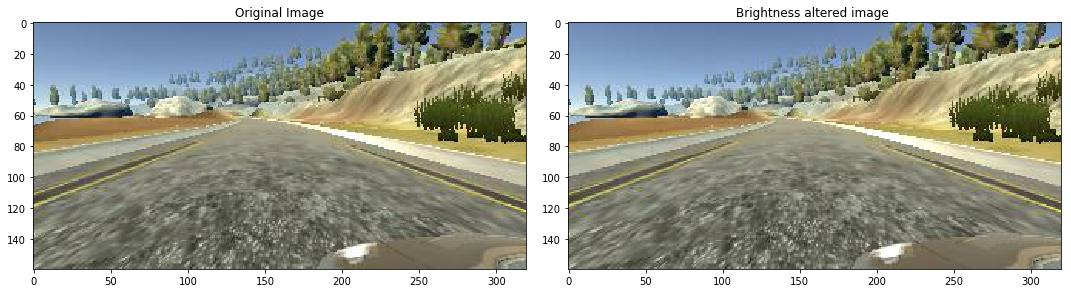

In [773]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [0]:
# This functions applies the image processing and the random augment functions on the data set in batches

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  


In [0]:
# Batch generator is being applied on training set and validation set

x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

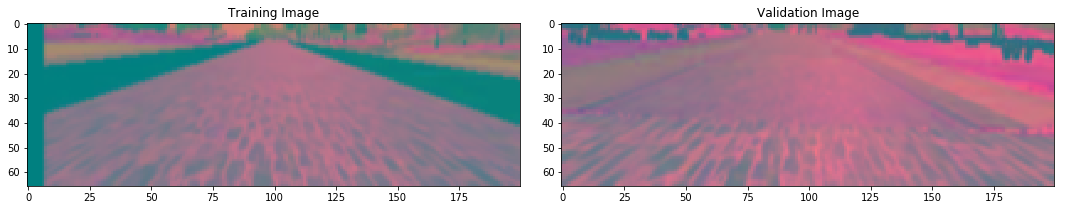

In [780]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# Here is the ML model used by nvidia with 5 convolutional neural networks and 3 dense layers

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  adam = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer = adam)
  return model

In [782]:
# summary for the model is being diplayed

model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_18 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [783]:
# This code fits the model to our processed and augmented data set

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs = 10,
                                  validation_data = batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps = 200,
                                  verbose = 1,
                                  shuffle = 1
                                  )

Epoch 1/10
300/300 [==============================] - 139s 463ms/step - loss: 0.0876 - val_loss: 0.0625
Epoch 2/10
300/300 [==============================] - 133s 442ms/step - loss: 0.0709 - val_loss: 0.0532
Epoch 3/10
300/300 [==============================] - 133s 444ms/step - loss: 0.0679 - val_loss: 0.0468
Epoch 4/10
300/300 [==============================] - 134s 447ms/step - loss: 0.0610 - val_loss: 0.0445
Epoch 5/10
300/300 [==============================] - 135s 449ms/step - loss: 0.0566 - val_loss: 0.0378
Epoch 6/10
300/300 [==============================] - 133s 445ms/step - loss: 0.0515 - val_loss: 0.0371
Epoch 7/10
300/300 [==============================] - 133s 445ms/step - loss: 0.0499 - val_loss: 0.0348
Epoch 8/10
300/300 [==============================] - 134s 445ms/step - loss: 0.0479 - val_loss: 0.0324
Epoch 9/10
300/300 [==============================] - 133s 442ms/step - loss: 0.0451 - val_loss: 0.0361
Epoch 10/10
300/300 [==============================] - 132s 441m

Text(0.5, 0, 'epochs')

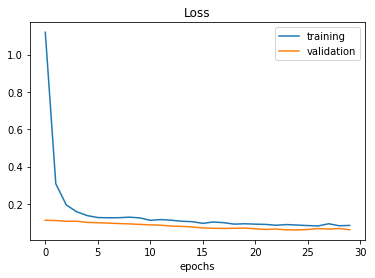

In [784]:
# Plotting the loss and validation loss 

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epochs')


In [0]:
# Saving the model

model.save('model.h5')

In [0]:
# Download the model

from google.colab import files
files.download('model.h5')